In [5]:
#========================================================================
# Copyright 2019 Science Technology Facilities Council
# Copyright 2019 University of Manchester
#
# This work is part of the Core Imaging Library developed by Science Technology	
# Facilities Council and University of Manchester
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0.txt
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# 
#=========================================================================

## Framework basics:
### Data containers, Geometry, Processors

### Learning objectives
In this excercise you will learn standard CT acquisition geometries and learn how they translate into Framework objects. We will also introduce other building blocks of the Framework which we will reuse in following excercises. 

### Prerequisites
Users are expected to be familiar with Python and object-oriented programming. A gentle introduction to Python can be found here: link

**TODO**: Edo, do you have a good link?

### CT geometry

In conventional CT systems, an object is placed between a source emitting X-rays and a detector array measuring the  X-ray transmission images of the incident X-rays. Typically, either the object is placed on a rotating sample stage and rotates with respect to the source-detector assembly, or the source-detector gantry rotates with respect to the stationary object. This arrangement results in so-called *circular scanning trajectory*. Depending on source and detector types, there are three conventional data acquisition geometries:
 - *Parallel geometry*: parallel beams of X-rays are emitted onto 1D (single pixel row) or 2D detector array. This geometry is common for synchrotron sources.
 - *Fan-beam geometry*: a single point-like X-ray source emits a cone beam onto 1D detector pixel row. Cone-beam is typically collimated to imaging field of view. Collimation allows greatly reduce amount of scatter radiation reaching the detector. Fan-beam geometry is used when scattering has significant influence on image quality or single-slice reconstruction is sufficient.
 - *Cone-beam geometry*: a single point-like X-ray source emits a cone beam onto 2D detector array. Cone-beam geometry is mainly used in lab-based CT instruments.

**TODO**: Question: can we use figures from papers/ books? authors permission?

In the Framework, we implemented `AcquisitionGeometry` class describing acquisition geometries. The simplest (of course from image processing point of view, not from physical implementation) geometry is the parallel geometry.

In [19]:
from ccpi.framework import AcquisitionGeometry
import numpy as np

# acquisition angles
n_angles = 90
angles = np.linspace(0, np.pi, n_angles, dtype=np.float32)

# number of pixels in detector row
N = 256

ag = AcquisitionGeometry(geom_type = 'parallel',
                        dimension = '2D',
                        angles = angles,
                        pixel_num_h = N,
                        pixel_size_h = 1)

`AcquisitionGeometry` contains only metadata, the actual data is stored in `AcquisitionData` class.

In [23]:
from ccpi.framework import AcquisitionData

# allocate AcquisitionData
ad = ag.allocate()

print(ad)
print('Dimensions and Labels  =  {}, {}'.format(ad.shape, ad.dimension_labels))

Number of dimensions: 2
Shape: (90, 256)
Axis labels: {0: u'angle', 1: u'horizontal'}

Dimensions and Labels  =  (90, 256), {0: u'angle', 1: u'horizontal'}


We can pass actual sinogram to AcquisitionData.

**TODO**: we need to add sinogram, flat and dark images to test data.

In [21]:
# ad.array = sinogram

As X-ray photons travel from an X-ray source to detector elements they interact with matter along their trajectories. In these interactions, photons are either absorbed or scattered, resulting in the attenuation of the incident X-ray. A quantitative description of the interaction of X-rays with matter is given by the Beer-Lambert law (or Beer’s law).
$$I^{\boldsymbol{l}} = I^0 \mathrm{exp}\left( -\int_{\boldsymbol{l}} f(\boldsymbol{g}) \mathrm{d}\boldsymbol{l} \right)$$
where $f(\boldsymbol{g})$ is the X-ray linear attenuation coefficient of the object at the position $\boldsymbol{g}$ along a given linear X-ray trajectory $\boldsymbol{l}$ from the source to the detector element. If $\boldsymbol{l}$ is the entire trajectory from the source to the detector element, then $I^0$ corresponds to the X-ray intensity upon emission from the source and $I^{\boldsymbol{l}}$ corresponds to the X-ray intensity upon incidence on the detector element. $I^{\boldsymbol{l}}$ is typically called a transmission measurement, whereas a projection measurement is given by
$$G^{\boldsymbol{l}} = -\log \left( \frac{I^{\boldsymbol{l}}}{I^0} \right) = \int_{\boldsymbol{l}} f(\boldsymbol{g}) \mathrm{d}\boldsymbol{l}$$

Ideally, $I^0$ is a single value, but real detector pixels do respond equally to photon flux. Secondly, pixels might have residual charge (so called dark current). Therefore, to convert $I^{\boldsymbol{l}}$ to $G^{\boldsymbol{l}}$, one needs to perform flat field correction. If $I^F$ is a flat field image (acquired with source on, without an object in the field of view) and $I^d$ is a dark field image (acquired with source off), then flat field correction is given by:
$$\frac{I-I^D}{I^F-I^D}$$

To perform flat field correction (and other mathematical operations), we defined arithmetic operations for `AcquisitionData` class.

In [35]:
# load flat and dark field images and wrap them as AcquisitionData objects
ag_f = ag.clone()
ag_f.angles = np.array([0], dtype = np.float32)
ag_d = ag_f.clone()
flat = ag_f.allocate()
#flat.array = flat_tmp
dark = ag_d.allocate()
#dark.array = dark_tmp

# and perform flat field correction and take negative logarithm
#sino = -log((ad - dark) / (flat - dark))

Number of dimensions: 2D
angles: [0.]
voxel_num : h256,v0
voxel size: h1,v1
geometry type: parallel
distance source-detector: None
distance center-detector: None
number of channels: 1



**TO DISCUSS**: what I do not like, is that for real imagesthis might not work because of zero division and -log(0). Thoughts?

Now, the data is ready for reconstruction.

Here are some examples of other arithmetic operations. Note, that there is alternative syntaxis for some operations.

In [22]:
a = ag.allocate(2)
b = ag.allocate(3)
print('a \n{}\n'.format(a.as_array()))
print('b \n{}\n'.format(b.as_array()))
## binary operations
c = a + b
print('a + b \n{}\n'.format(c.as_array()))
# or alternatively
c = a.add(b)
print('a + b \n{}\n'.format(c.as_array()))
d = 3 ** a
print('3 ** a \n{}\n'.format(d.as_array()))
e = a ** b
print('a ** b \n{}\n'.format(e.as_array()))
f = a.maximum(b)
print('max(a,b) \n{}\n'.format(f.as_array()))

## in-place operations
b **= b
print('b ** b \n{}\n'.format(b.as_array()))
a += b
print('a + b \n{}\n'.format(a.as_array()))
# or alternatively
a.add(b, out = a)
print('a + b \n{}\n'.format(a.as_array()))

## unary operation
g = a.sign()
print('sign(a) \n{}\n'.format(g.as_array()))

## reductions
h = a.norm()
print('norm(a) \n{}\n'.format(h))
i = a.dot(b)
print('dot(a,b) \n{}\n'.format(i))

a 
[[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]]

b 
[[3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]
 ...
 [3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]]

a + b 
[[5. 5. 5. ... 5. 5. 5.]
 [5. 5. 5. ... 5. 5. 5.]
 [5. 5. 5. ... 5. 5. 5.]
 ...
 [5. 5. 5. ... 5. 5. 5.]
 [5. 5. 5. ... 5. 5. 5.]
 [5. 5. 5. ... 5. 5. 5.]]

a + b 
[[5. 5. 5. ... 5. 5. 5.]
 [5. 5. 5. ... 5. 5. 5.]
 [5. 5. 5. ... 5. 5. 5.]
 ...
 [5. 5. 5. ... 5. 5. 5.]
 [5. 5. 5. ... 5. 5. 5.]
 [5. 5. 5. ... 5. 5. 5.]]

3 ** a 
[[9. 9. 9. ... 9. 9. 9.]
 [9. 9. 9. ... 9. 9. 9.]
 [9. 9. 9. ... 9. 9. 9.]
 ...
 [9. 9. 9. ... 9. 9. 9.]
 [9. 9. 9. ... 9. 9. 9.]
 [9. 9. 9. ... 9. 9. 9.]]

a ** b 
[[8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 ...
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]]

max(a,b) 
[[3. 3. 3. .

Following operations are defined:
binary operations (between two DataContainers or scalar and DataContainer)
- \+ addition
- \- subtraction
- \/ division
- \* multiplication
- \** power
- maximum
- minimum
    
in-place operations
- \+= 
- \-= 
- \*=
- \**=
- /=     

unary operations
- abs
- sqrt
- sign
- conjugate
    
reductions
- minimum
- maximum
- sum
- norm
- dot product

Fan-beam geometry and cone-beam geometry can be set-up similar to parallel geometry.

In [ ]:
# fan-beam geometry
ag_fan = AcquisitionGeometry(geom_type = 'cone', 
                             dimension = '2D', 
                             angles = angles, 
                             pixel_num_h = N, 
                             pixel_size_h = 1, 
                             dist_source_center = 200, 
                             dist_center_detector = 300)

# cone-beam geometry
ag_cone = AcquisitionGeometry(geom_type = 'cone', 
                             dimension = '3D', 
                             angles = angles, 
                             pixel_num_h = N, 
                             pixel_size_h = 1, 
                             pixel_num_v = N, 
                             pixel_size_v = 1, 
                             dist_source_center = 200, 
                             dist_center_detector = 300)

print(ag_fan)
print(ag_cone)

All three geometries can be defined for spectral (multi-channel) data.

In [36]:
# multi-channel fan-beam geometry
ag_fan_mc = AcquisitionGeometry(geom_type = 'cone', 
                                 dimension = '2D', 
                                 angles = angles, 
                                 pixel_num_h = N, 
                                 pixel_size_h = 1, 
                                 dist_source_center = 200, 
                                 dist_center_detector = 300,
                                 channels = 10)

print(ag_fan_mc)

Number of dimensions: 2D
angles: [0.         0.03529879 0.07059759 0.10589638 0.14119518 0.17649397
 0.21179277 0.24709156 0.28239036 0.31768915 0.35298795 0.38828674
 0.42358553 0.45888433 0.49418312 0.5294819  0.5647807  0.6000795
 0.6353783  0.67067707 0.7059759  0.74127465 0.7765735  0.81187224
 0.84717107 0.88246983 0.91776866 0.9530674  0.98836625 1.0236651
 1.0589638  1.0942626  1.1295614  1.1648602  1.200159   1.2354578
 1.2707566  1.3060554  1.3413541  1.376653   1.4119518  1.4472506
 1.4825493  1.5178481  1.553147   1.5884458  1.6237445  1.6590433
 1.6943421  1.7296408  1.7649397  1.8002385  1.8355373  1.870836
 1.9061348  1.9414337  1.9767325  2.0120313  2.0473301  2.0826287
 2.1179276  2.1532264  2.1885252  2.223824   2.2591228  2.2944217
 2.3297205  2.365019   2.400318   2.4356167  2.4709156  2.5062144
 2.5415132  2.576812   2.6121109  2.6474094  2.6827083  2.718007
 2.753306   2.7886047  2.8239036  2.8592024  2.8945012  2.9297998
 2.9650986  3.0003974  3.0356963  3.070995

3D data can be easily reduced to 2D (or multi-channel to single-channel) by using `subset` method.

In [37]:
# allocate multi-channel fan-beam acquisition data
ad_fan_mc = ag_fan_mc.allocate()

# extract single channel using subset method
ad_fan_sc = ad_fan_mc.subset(channel = 5)
ag_fan_sc = ad_fan_mc.geometry

print(ag_fan_sc)
print('Dimensions and Labels  =  {}, {}'.format(ag_fan_mc.shape, ag_fan_mc.dimension_labels))

TypeError: __init__() takes at least 4 arguments (5 given)

To store reconstruction results, we implemented two classes:`ImageGeometry` and `ImageData` class. `AcquisiionData` and `ImageData` inherit from the same parent clss, therefore they behave the same way. The only difference is the metadata. Define 2D `ImageGeometry` and allocate `ImageData`.

In [4]:
from ccpi.framework import ImageData, ImageGeometry

# Define 2D ImageGeometry
ig = ImageGeometry(voxel_num_y = 5, voxel_num_x = 4)

# Create random ImageData with the specific geometry
im_data1 = ig.allocate()
im_data2 = ig.allocate('random', seed = 5)

In [5]:
print('Allocate with zeros \n{}\n'.format(im_data1.as_array()))
print('Allocate with random numbers in [0,1] \n{}\n'.format(im_data2.as_array()))
print('Dimensions and Labels = {} , {}'.format(im_data1.shape, im_data1.dimension_labels))

Allocate with zeros 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Allocate with random numbers in [0,1] 
[[0.22199318 0.8707323  0.20671916 0.91861093]
 [0.4884112  0.61174387 0.7659079  0.518418  ]
 [0.2968005  0.18772122 0.08074127 0.7384403 ]
 [0.4413092  0.15830986 0.87993705 0.27408648]
 [0.41423503 0.29607993 0.62878793 0.5798378 ]]

Dimensions and Labels = (5, 4) , {0: u'horizontal_y', 1: u'horizontal_x'}


Define multi-channels `ImageGeometry` and allocate `ImageData`.

In [6]:
# Define 2D + channels ImageGeometry
ig1 = ImageGeometry(voxel_num_y = 5, voxel_num_x = 4, channels = 2)

# Create random integer in [0, max_value] ImageData with the specific geometry
im_data3 = ig1.allocate('random_int', seed = 10, max_value = 500)

print('Allocate with random integers \n{}\n'.format(im_data3.as_array()))
print('Dimensions and Labels  =  {}, {}'.format(im_data3.shape, im_data3.dimension_labels))

Allocate with random integers 
[[[265. 125. 484.  15.]
  [320. 369. 123. 156.]
  [473. 221. 496. 413.]
  [369.   8.  73. 256.]
  [490.  40. 420. 371.]]

 [[ 16. 356. 239. 395.]
  [ 54. 344. 363. 122.]
  [ 62.  33. 200. 356.]
  [462. 177. 179.  54.]
  [ 77. 453.  13. 243.]]]

Dimensions and Labels =  ((2, 5, 4), [u'channel', u'horizontal_y', u'horizontal_x'])


The Framework provides a number of test images

- BOAT = 'boat.tiff'
- CAMERA = 'camera.png'
- PEPPERS = 'peppers.tiff'
- RESOLUTION_CHART = 'resolution_chart.tiff'
- SIMPLE_PHANTOM_2D = 'hotdog'
- SHAPES = 'shapes.png'
    
Here we load a 'hotdog' image (a simple CT phantom consisting of 2 materials)

('data.geometry', <ccpi.framework.framework.ImageGeometry object at 0x7f871747fed0>)
Number of channels: 1
voxel_num : x200,y200,z0
voxel_size : x1,y1,z1
center : x0,y0,z0

Dimensions and Labels  =  (200, 200), {0: u'horizontal_x', 1: u'horizontal_y'}


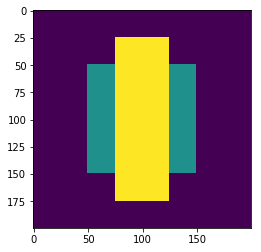

In [42]:
from ccpi.framework import TestData
import matplotlib.pyplot as plt
import os, sys

%matplotlib inline

loader = TestData(data_dir=os.path.join(sys.prefix, 'share','ccpi'))
data = loader.load(TestData.SIMPLE_PHANTOM_2D, size=(200,200))
ig = data.geometry
print(ig)
print('Dimensions and Labels  =  {}, {}'.format(data.shape, data.dimension_labels))

# plot data
plt.imshow(data.as_array())
plt.show()

Similar to `AcquisitionData', 'ImageData' provides a simple method to produce a subset of itself based on the axis we would like to have. 

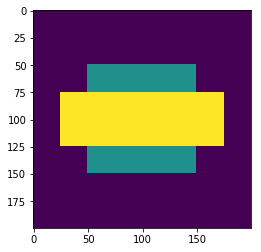

ValueError: Number of dimensions are not 2 or 3 or 4 : 1

In [43]:
# transpose data using subset method
data_subset = data.subset(['horizontal_y', 'horizontal_x'])

plt.imshow(data_subset.as_array())
plt.show()

# extract single row
data_profile = data_subset.subset(horizontal_y = 100)

plt.plot(data_profile.as_array())
plt.show()


**OLD STUFF BELOW**

Framework supports aa number of standard CT acquisition geometries, namely:
    - parallel beam
    - fan beam
    - cone beam.
    
The parallel beam geometry is the simplest one. A user needs to specify only acquisition angles and a number of pixels in a detector array. We load AcquisitionData from NEXUS file.

Acquisition data 

Number of dimensions: 3
Shape: (91, 135, 160)
Axis labels: {0: u'angle', 1: u'vertical', 2: u'horizontal'}

Acquisition geometry 

Number of dimensions: 3D
angles: [-88.2    -86.2    -84.2001 -82.2    -80.2    -78.2    -76.1999 -74.2
 -72.1999 -70.2    -68.2    -66.2    -64.1999 -62.2    -60.2    -58.2
 -56.2    -54.2    -52.2    -50.2    -48.2    -46.2    -44.1999 -42.1999
 -40.2    -38.2    -36.1997 -34.2    -32.2    -30.2    -28.2    -26.2
 -24.2    -22.2    -20.2    -18.2    -16.2    -14.2    -12.2    -10.1999
  -8.2     -6.2     -4.1999  -2.2     -0.2      1.8      3.8001   5.8
   7.8      9.8     11.7999  13.8     15.7999  17.8     19.8     21.8
  23.8     25.8     27.8     29.8     31.8     33.8     35.8     37.8
  39.8     41.8     43.7999  45.8     47.8     49.8     51.8     53.8
  55.8     57.8     59.8     61.8     63.8     65.8     67.8001  69.8
  71.8     73.8     75.8     77.8     79.8     81.8     83.8     85.8
  87.8     89.8     91.7999]
voxel_num : 

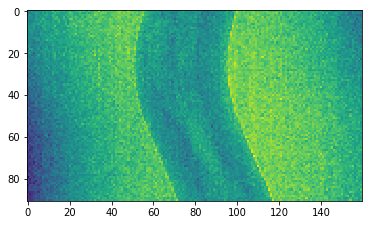

In [28]:
from ccpi.framework import AcquisitionGeometry, AcquisitionData
from ccpi.io import NEXUSDataReader
import numpy

# load AcquisitionData and Acquisition Geometry from NEXUS file
filename = os.path.join(os.environ['SIRF_INSTALL_PATH'], 'share','ccpi','24737_fd_normalised.nxs')
reader = NEXUSDataReader()
reader.set_up(nexus_file = filename)
acquisition_data = reader.load_data()
print('Acquisition data \n')
print(acquisition_data)
ag = reader.get_geometry()
print('Acquisition geometry \n')
print(ag)

#TODO Extract one slice from acquistion data.
#acquisition_data_slice = acquisition_data.subset(horizontal = 30)
#print(acquisition_data.geometry)

# visualise sinogram for a single slice
plt.imshow(acquisition_data.as_array()[:,30,:])
plt.show()

We can create Acquisition geometry from scratch and allocate empty AcquisitionData

In [33]:
# number of acquisition angles
angles_num = 20
# detector pixel width
det_w = 1.0
# number of pixels in a detector row
det_h = 200
# number of pixels in a detector column
det_v = 200
# distance from source to centre of rotation
dist_source_center = 300
# distance from centre of rotation to detetctor
dist_center_detector = 300
# acquisition angles
angles = numpy.linspace(0, numpy.pi, angles_num, endpoint = False)
# create acquisition geometry
ag_cone = AcquisitionGeometry(geom_type='cone',
                              dimension='2D',
                              angles=angles,
                              pixel_num_h=det_h,
                              pixel_size_h=det_w,
                              pixel_num_v=det_v,
                              pixel_size_v=det_w,
                              dist_source_center=dist_source_center,
                              dist_center_detector=dist_center_detector)  

# allocate AcquisitionData
acquisition_data_cone = ag_cone.allocate()
print('Acquisition geometry \n {}\nAcquisition data \n {}\nArray \n {}\n'.format(ag_cone, acquisition_data_cone, acquisition_data_cone.as_array()))

Acquisition geometry 
 Number of dimensions: 3D
angles: [0.         0.15707963 0.31415927 0.4712389  0.62831853 0.78539816
 0.9424778  1.09955743 1.25663706 1.41371669 1.57079633 1.72787596
 1.88495559 2.04203522 2.19911486 2.35619449 2.51327412 2.67035376
 2.82743339 2.98451302]
voxel_num : h200,v200
voxel size: h1.0,v1.0
geometry type: cone
distance source-detector: 300
distance center-detector: 300
number of channels: 1

Acquisition data 
 Number of dimensions: 3
Shape: (20, 200, 200)
Axis labels: {0: u'angle', 1: u'vertical', 2: u'horizontal'}

 Array 
 [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.

Finally, we will show multi-channel fan-beam geometry

In [35]:
# number of channels
n_channels = 100

ag_fan = AcquisitionGeometry(geom_type='cone',
                             dimension='2D',
                             angles=angles,
                             pixel_num_h=det_h,
                             pixel_size_h=det_w,
                             dist_source_center=dist_source_center,
                             dist_center_detector=dist_center_detector,
                             channels=n_channels) 

# allocate AcquisitionData
acquisition_data_fan = ag_fan.allocate()
print('Acquisition geometry \n {}\nAcquisition data \n {}\nArray \n {}\n'.format(ag_fan, acquisition_data_fan, acquisition_data_fan.as_array()))

Acquisition geometry 
 Number of dimensions: 2D
angles: [0.         0.15707963 0.31415927 0.4712389  0.62831853 0.78539816
 0.9424778  1.09955743 1.25663706 1.41371669 1.57079633 1.72787596
 1.88495559 2.04203522 2.19911486 2.35619449 2.51327412 2.67035376
 2.82743339 2.98451302]
voxel_num : h200,v0
voxel size: h1.0,v1
geometry type: cone
distance source-detector: 300
distance center-detector: 300
number of channels: 100

Acquisition data 
 Number of dimensions: 3
Shape: (100, 20, 200)
Axis labels: {0: u'channel', 1: u'angle', 2: u'horizontal'}

Array 
 [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  

AcquisitionData is subclass of DataContainer consequently all arithmetic operations can be also performed on AcquisitionData (as we have seen for ImageData).

In [36]:
a = ag_fan.allocate(2)
b = ag_fan.allocate(3)

c = a ** b

print('a ** b \n{}\n'.format(c.as_array()))
print('Acquisition geometry of a ** b\n{}\n'.format(c.geometry))

a ** b 
[[[8. 8. 8. ... 8. 8. 8.]
  [8. 8. 8. ... 8. 8. 8.]
  [8. 8. 8. ... 8. 8. 8.]
  ...
  [8. 8. 8. ... 8. 8. 8.]
  [8. 8. 8. ... 8. 8. 8.]
  [8. 8. 8. ... 8. 8. 8.]]

 [[8. 8. 8. ... 8. 8. 8.]
  [8. 8. 8. ... 8. 8. 8.]
  [8. 8. 8. ... 8. 8. 8.]
  ...
  [8. 8. 8. ... 8. 8. 8.]
  [8. 8. 8. ... 8. 8. 8.]
  [8. 8. 8. ... 8. 8. 8.]]

 [[8. 8. 8. ... 8. 8. 8.]
  [8. 8. 8. ... 8. 8. 8.]
  [8. 8. 8. ... 8. 8. 8.]
  ...
  [8. 8. 8. ... 8. 8. 8.]
  [8. 8. 8. ... 8. 8. 8.]
  [8. 8. 8. ... 8. 8. 8.]]

 ...

 [[8. 8. 8. ... 8. 8. 8.]
  [8. 8. 8. ... 8. 8. 8.]
  [8. 8. 8. ... 8. 8. 8.]
  ...
  [8. 8. 8. ... 8. 8. 8.]
  [8. 8. 8. ... 8. 8. 8.]
  [8. 8. 8. ... 8. 8. 8.]]

 [[8. 8. 8. ... 8. 8. 8.]
  [8. 8. 8. ... 8. 8. 8.]
  [8. 8. 8. ... 8. 8. 8.]
  ...
  [8. 8. 8. ... 8. 8. 8.]
  [8. 8. 8. ... 8. 8. 8.]
  [8. 8. 8. ... 8. 8. 8.]]

 [[8. 8. 8. ... 8. 8. 8.]
  [8. 8. 8. ... 8. 8. 8.]
  [8. 8. 8. ... 8. 8. 8.]
  ...
  [8. 8. 8. ... 8. 8. 8.]
  [8. 8. 8. ... 8. 8. 8.]
  [8. 8. 8. ... 8. 8. 8.]]]

A

### Summary